## Peer-graded Assignment: Segmenting and Clustering Neighborhoods in Toronto
### Phase1: Load the Postal Codes in a DataFrame

In [1]:
import pandas as pd
import qgrid
import urllib.request
import pandas as pd

pd.options.display.max_rows = 999

# function to print out dataframe
def showQgrid(df):
    from IPython.display import display
    grid = qgrid.QGridWidget(df=df)
    QGridWidget = qgrid.show_grid(df.head(), show_toolbar=True)
    QGridWidget.get_changed_df()
    display(grid)

In [2]:
#Load Desired Table in Data Frame
WikiData = urllib.request.urlopen("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M").read()
WikiTables = pd.read_html(WikiData)
df_post = WikiTables[0]

#Only process the cells that have an assigned borough. Ignore cells with a borough that is Not assigned.
df_post_table = df_post[ df_post['Borough'] != "Not assigned"]

## Solution 1 In the last cell of your notebook, use the .shape method to print the number of rows of your dataframe.

In [3]:
df_post_table.shape

(103, 3)

In [4]:
df_post_table

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


### Phase2: Load the Locations in a DataFrame    

In [5]:
GeoData = pd.read_csv("https://cocl.us/Geospatial_data")

In [6]:
df_loc = pd.merge(df_post,GeoData,left_on='Postal Code',right_on='Postal Code')

## Solution 2 : Print out the Postal Code Dataframe

In [7]:
df_loc

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494
...,...,...,...,...,...
98,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North",43.653654,-79.506944
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160
100,M7Y,East Toronto,"Business reply mail Processing Centre, South C...",43.662744,-79.321558
101,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu...",43.636258,-79.498509


### Phase3: Cluster the locations in Toronto

In [8]:
#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

In [9]:
address = 'Toronto'
geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
#print('The geograpical coordinate of Toronto are {}, {}.'.format(latitude, longitude))


# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(df_loc['Latitude'], df_loc['Longitude'], df_loc['Borough'], df_loc['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### 3.1 Retrieve Venue Details from Foursquare

In [10]:
CLIENT_ID = 'UAKLSDGE4CSMD3AA53HLK524Y4ELAS00ATYDLXY41QJWMDCK' # your Foursquare ID
CLIENT_SECRET = 'IQYOKO3UWLKNKIHF3JAFDNE5SPPFWL2IIEN1BJ53GK34GYVC' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [11]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    LIMIT = 100
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Toronto_venues = getNearbyVenues(names=df_loc['Neighbourhood'],
                                   latitudes=df_loc['Latitude'],
                                   longitudes=df_loc['Longitude']
                                  )

In [12]:
Toronto_venues.shape

(2147, 7)

In [13]:
eateries_list = [
    'Afghan Restaurant',
'American Restaurant',
'Bar',
'Cajun / Creole Restaurant',
'Cocktail Bar',
'Colombian Restaurant',
'Comfort Food Restaurant',
'Creperie',
'Cuban Restaurant',
'Doner Restaurant',
'Dumpling Restaurant',
'Eastern European Restaurant',
'Ethiopian Restaurant',
'Fast Food Restaurant',
'Fish & Chips Shop',
'Food Court',
'French Restaurant',
'Gay Bar',
'Gluten-free Restaurant',
'Greek Restaurant',
'Hakka Restaurant',
'Health Food Store',
'Indian Restaurant',
'Italian Restaurant',
'Japanese Restaurant',
'Latin American Restaurant',
'Mediterranean Restaurant',
'Middle Eastern Restaurant',
'Moroccan Restaurant',
'New American Restaurant',
'Portuguese Restaurant',
'Salad Place',
'Smoothie Shop',
'Taco Place',
'Thai Restaurant',
'Wine Bar',
'Asian Restaurant',
'Bagel Shop',
'Bakery',
'BBQ Joint',
'Beer Bar',
'Belgian Restaurant',
'Bistro',
'Brazilian Restaurant',
'Breakfast Spot',
'Bubble Tea Shop',
'Burger Joint',
'Burrito Place',
'Café',
'Cafeteria',
'Caribbean Restaurant',
'Cheese Shop',
'Chinese Restaurant',
'Chocolate Shop',
'Coffee Shop',
'Cupcake Shop',
'Dessert Shop',
'Dim Sum Restaurant',
'Donut Shop',
'Falafel Restaurant',
'Farmers Market',
'Filipino Restaurant',
'Food & Drink Shop',
'German Restaurant',
'Hotel Bar',
'Ice Cream Shop',
'Indonesian Restaurant',
'Irish Pub',
'Juice Bar',
'Korean Restaurant',
'Mexican Restaurant',
'Modern European Restaurant',
'Molecular Gastronomy Restaurant',
'Noodle House',
'Persian Restaurant',
'Pizza Place',
'Pub',
'Ramen Restaurant',
'Restaurant',
'Sandwich Place',
'Seafood Restaurant',
'Steakhouse',
'Sushi Restaurant',
'Taiwanese Restaurant',
'Theme Restaurant',
'Vegetarian / Vegan Restaurant',
'Vietnamese Restaurant']

In [14]:
Toronto_venues_subset2 = Toronto_venues[Toronto_venues['Venue Category'].str.contains('|'.join(eateries_list))]

In [15]:
Toronto_venues_Group3 = pd.pivot_table(Toronto_venues_subset2, 
                                       index=['Neighbourhood'],
                                       values=['Venue Category'], aggfunc=len,fill_value=0)

Toronto_venues_Group3.reset_index(inplace=True)
Toronto_venues_Group3.rename(columns={"Venue Category": "Count of Eateries"},inplace=True)
showQgrid(Toronto_venues_Group3)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [16]:
searchfor = ['Pizza Place', 'Italian Restaurant']
Toronto_venues_subset = Toronto_venues[Toronto_venues['Venue Category'].str.contains('|'.join(searchfor))]

#showQgrid(Toronto_venues_subset)

In [17]:
Toronto_venues_Group4 = pd.pivot_table(Toronto_venues_subset, 
                                       index=['Neighbourhood'],
                                       values=['Venue Category'], aggfunc=len,fill_value=0)

Toronto_venues_Group4.reset_index(inplace=True)
Toronto_venues_Group4.rename(columns={"Venue Category": "Count of Competition"},inplace=True)
showQgrid(Toronto_venues_Group4)


QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

In [126]:
#The Final Dataframe ready to be clustered
Toronto_merged3 = df_loc.join(Toronto_venues_Group4.set_index('Neighbourhood'), on='Neighbourhood')
Toronto_merged3 = Toronto_merged3.join(Toronto_venues_Group3.set_index('Neighbourhood'), on='Neighbourhood')

Toronto_merged3['Count of Competition'] = Toronto_merged3["Count of Competition"].fillna(0)
Toronto_merged3['Count of Eateries'] = Toronto_merged3["Count of Eateries"].fillna(0)
showQgrid(Toronto_merged3)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

### The Distribution of Data before the Clustering Analysis

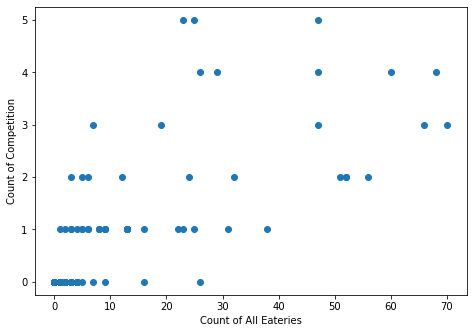

In [127]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

y = Toronto_merged3['Count of Competition']
x = Toronto_merged3['Count of Eateries']
ax.set_ylabel('Count of Competition')
ax.set_xlabel('Count of All Eateries')
scatter = ax.scatter(x, y)
plt.show()

In [128]:
Toronto_merged3.describe()

,Latitude,Longitude,Count of Competition,Count of Eateries
count,103.000000,103.000000,103.000000,103.000000
mean,43.704608,-79.397153,0.922330,12.077670
std,0.052463,0.097146,1.318714,17.723746
min,43.602414,-79.615819,0.000000,0.000000
25%,43.660567,-79.464763,0.000000,1.000000
50%,43.696948,-79.388790,0.000000,4.000000
75%,43.745320,-79.340923,1.000000,14.500000
max,43.836125,-79.160497,5.000000,70.000000


In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

X = Toronto_merged3.iloc[: ,5:7]
X.head()

,Count of Competition,Count of Eateries
0,0.0,1.0
1,0.0,3.0
2,0.0,26.0
3,0.0,2.0
4,1.0,22.0


In [20]:
X = preprocessing.StandardScaler().fit(X).transform(X)

### 3.3 Cluster the Neighborhoods

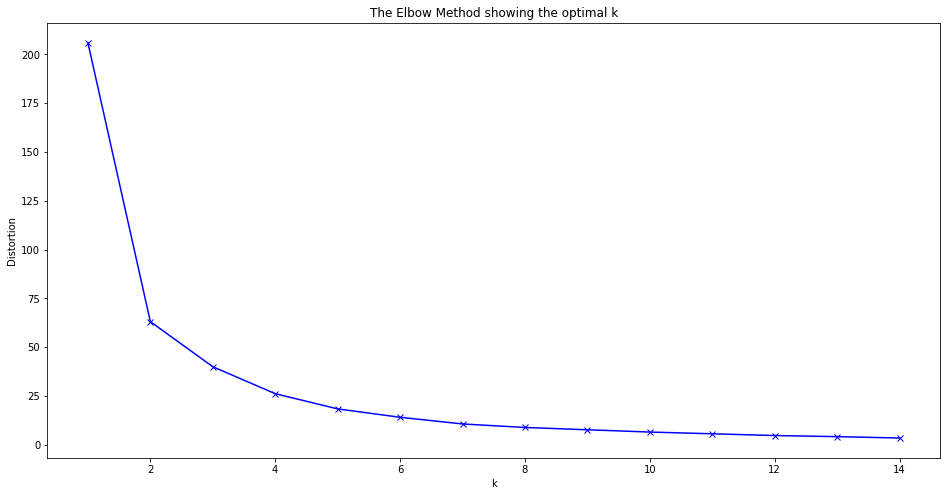

In [129]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import KMeans

distortions = []
K = range(1,15)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(X)
    distortions.append(kmeanModel.inertia_)

# Plot the elbow
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [130]:
# set number of clusters
kmeanModel = KMeans(n_clusters=7)
kmeanModel.fit(X)

Toronto_merged3.insert(7, 'Cluster Labels', kmeanModel.labels_)

In [131]:
showQgrid(Toronto_merged3)

QgridWidget(grid_options={'fullWidthRows': True, 'syncColumnCellResize': True, 'forceFitColumns': True, 'defau…

## Solution 3 : Clustering Analysis Results

### Distribution of Clusters

In [134]:
Toronto_merged3[['Cluster Labels',
                 'Count of Competition',
                 'Count of Eateries']].groupby('Cluster Labels').agg(['mean', 'count','min','max'])

Count of Competition                 Count of Eateries        \
                               mean count  min  max              mean count   
Cluster Labels                                                                
0                          2.200000     5  2.0  3.0         51.600000     5   
1                          0.000000    54  0.0  0.0          1.722222    54   
2                          1.000000    20  1.0  1.0          7.950000    20   
3                          4.600000     5  4.0  5.0         30.000000     5   
4                          3.600000     5  3.0  4.0         62.200000     5   
5                          2.333333     6  2.0  3.0          8.666667     6   
6                          1.125000     8  0.0  2.0         27.625000     8   

                            
                 min   max  
Cluster Labels              
0               47.0  56.0  
1                0.0  16.0  
2                1.0  16.0  
3               23.0  47.0  
4               47.0  70.0  
5                3.0  19.0  
6               22.0  38.0

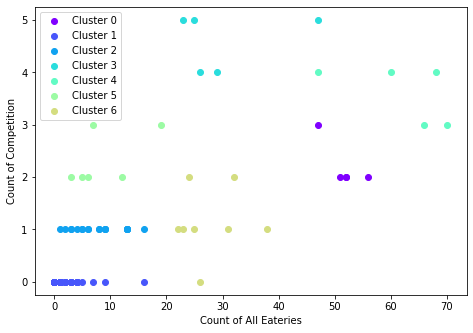

In [133]:
fig=plt.figure()
ax=fig.add_axes([0,0,1,1])

# set color scheme for the clusters
x = np.arange(k)
ys = [i + x + (i*x)**2 for i in range(10)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

for k in range(7):
    Toronto_Temp = Toronto_merged3.loc[Toronto_merged3['Cluster Labels'] == k]
    y = Toronto_Temp['Count of Competition']
    x = Toronto_Temp['Count of Eateries']
    colorlabel = int(k)
    legendlabel = "Cluster " + str(k)
    scatter = ax.scatter(x, y, color=rainbow[colorlabel],label=legendlabel)

ax.set_ylabel('Count of Competition')
ax.set_xlabel('Count of All Eateries')

ax.legend()

plt.show()


### The Optimum Locations Selected to Open the Pizzeria

In [135]:
Toronto_merged3.loc[Toronto_merged3['Cluster Labels'] == 0]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Count of Competition,Count of Eateries,Cluster Labels
15,M5C,Downtown Toronto,St. James Town,43.651494,-79.375418,2.0,52.0,0
24,M5G,Downtown Toronto,Central Bay Street,43.657952,-79.387383,3.0,47.0,0
30,M5H,Downtown Toronto,"Richmond, Adelaide, King",43.650571,-79.384568,2.0,56.0,0
84,M5T,Downtown Toronto,"Kensington Market, Chinatown, Grange Park",43.653206,-79.400049,2.0,51.0,0
99,M4Y,Downtown Toronto,Church and Wellesley,43.665860,-79.383160,2.0,52.0,0


In [136]:
Toronto_merged3.loc[Toronto_merged3['Cluster Labels'] == 6]

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Count of Competition,Count of Eateries,Cluster Labels
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636,0.0,26.0,6
4,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.662301,-79.389494,1.0,22.0,6
20,M5E,Downtown Toronto,Berczy Park,43.644771,-79.373306,1.0,38.0,6
33,M2J,North York,"Fairview, Henry Farm, Oriole",43.778517,-79.346556,1.0,31.0,6
37,M6J,West Toronto,"Little Portugal, Trinity",43.647927,-79.419750,2.0,32.0,6
54,M4M,East Toronto,Studio District,43.659526,-79.340923,1.0,23.0,6
59,M2N,North York,"Willowdale, Willowdale East",43.770120,-79.408493,2.0,24.0,6
80,M5S,Downtown Toronto,"University of Toronto, Harbord",43.662696,-79.400049,1.0,25.0,6


In [138]:
import numpy as np

kclusters = k
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(Toronto_merged3['Latitude'], Toronto_merged3['Longitude'], Toronto_merged3['Neighbourhood'], Toronto_merged3['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    colorlabel = int(cluster)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[colorlabel],
        fill=True,
        fill_color=rainbow[colorlabel],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters